# How to Develop Deep Learning Models for Univariate Time Series Forecasting

In [1]:
from math import sqrt
from numpy import mean
from numpy import median
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# Persistence Baseline Algorithm

In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [3]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))

    # put it all together
    agg = concat(cols, axis=1)
    
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [4]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [5]:
# fit a model
def model_fit(train, config):
    return None

# forecast with a pre-fit model
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return median(values)

In [6]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    
    # fit model
    model = model_fit(train, cfg)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [7]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

In [8]:
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    
    # box and whisker plot
    pyplot.boxplot(scores)

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


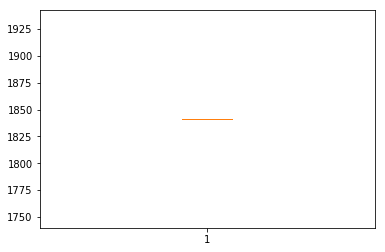

In [9]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values

# data split
n_test = 12

# define config
config = [12, 24, 36]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('persistence', scores)

# Multilayer Perceptron Model

In [10]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

In [11]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [12]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [13]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [14]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config

    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]

    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    return model

In [15]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [16]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [17]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

In [18]:
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    
    # box and whisker plot
    pyplot.boxplot(scores)

 > 1775.977
 > 1680.981
 > 1377.987
 > 1511.906
 > 1600.910
 > 1794.471
 > 1403.869
 > 1648.524
 > 1589.260
 > 1509.596
 > 1552.878
 > 1309.397
 > 1586.795
 > 1393.018
 > 1614.257
 > 1568.115
 > 1616.312
 > 1583.120
 > 1470.648
 > 1654.760
 > 1541.811
 > 1466.707
 > 1477.727
 > 1572.905
 > 1359.798
 > 1396.669
 > 1360.321
 > 1694.938
 > 1451.741
 > 1391.271
mlp: 1531.889 RMSE (+/- 124.017)


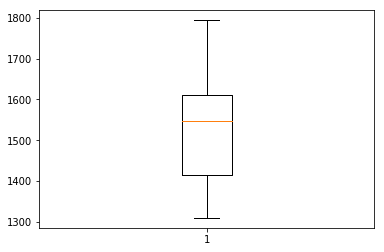

In [19]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values

# data split
n_test = 12

# define config
config = [24, 500, 100, 100]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('mlp', scores)

# Convolutional Neural Network Model

In [20]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from matplotlib import pyplot

In [21]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [22]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [23]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [24]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [25]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [26]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    
    # fit model
    model = model_fit(train, cfg)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [27]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

In [28]:
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)

 > 1495.830
 > 1588.983
 > 1562.926
 > 1490.754
 > 1358.305
 > 1498.892
 > 1615.806
 > 1503.609
 > 1489.552
 > 1592.685
 > 1497.344
 > 1558.306
 > 1481.946
 > 1475.276
 > 1629.163
 > 1534.316
 > 1551.608
 > 1535.631
 > 1590.744
 > 1568.503
 > 1444.453
 > 1547.722
 > 1417.544
 > 1475.059
 > 1676.495
 > 1463.793
 > 1596.966
 > 1598.078
 > 1684.437
 > 1537.310
cnn: 1535.401 RMSE (+/- 71.955)


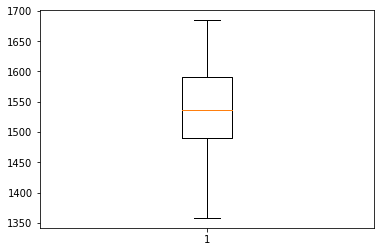

In [29]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values

# data split
n_test = 12

# define config
config = [36, 256, 3, 100, 100]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('cnn', scores)

# Recurrent Neural Network Models

## LSTM

In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from matplotlib import pyplot

In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [3]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [4]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [5]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [6]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
        
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [7]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
        
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    
    # forecast
    yhat = model.predict(x_input, verbose=0)
    
    return correction + yhat[0]

In [8]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [9]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

In [10]:
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

 > 2099.762
 > 2111.096
 > 2091.251
 > 1978.298
 > 2083.907
 > 2130.600
 > 1943.396
 > 2124.530
 > 2150.820
 > 2223.386
 > 2205.611
 > 2110.542
 > 2097.464
 > 2179.950
 > 2062.830
 > 2108.349
 > 2033.878
 > 2170.213
 > 2196.826
 > 2086.449
 > 2038.909
 > 2096.878
 > 2159.368
 > 2283.575
 > 2148.952
 > 2177.632
 > 2051.134
 > 2145.257
 > 2179.061
 > 2085.497
lstm: 2118.514 RMSE (+/- 70.028)


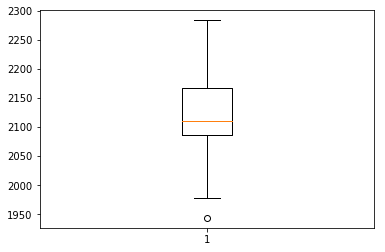

In [11]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values

# data split
n_test = 12

# define config
config = [36, 50, 100, 100, 12]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('lstm', scores)

## CNN LSTM

In [13]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from matplotlib import pyplot

In [14]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [15]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [16]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    
    # forecast
    yhat = model.predict(x_input, verbose=0)
    
    return yhat[0]

 > 1536.868
 > 1559.206
 > 1554.827
 > 1502.107
 > 1477.223
 > 1800.508
 > 3190.373
 > 1697.029
 > 1774.426
 > 1507.589
 > 1649.178
 > 1680.624
 > 1478.132
 > 1724.757
 > 1469.870
 > 1517.342
 > 1580.217
 > 1693.917
 > 1665.491
 > 1270.299
 > 1926.401
 > 1611.628
 > 1770.304
 > 1902.342
 > 1493.224
 > 1513.973
 > 1758.016
 > 1735.430
 > 1826.757
 > 1627.022
cnn-lstm: 1683.169 RMSE (+/- 314.608)


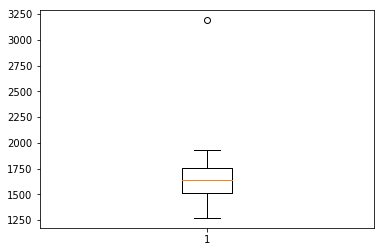

In [17]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values

# data split
n_test = 12

# define config
config = [3, 12, 64, 3, 100, 200, 100]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('cnn-lstm', scores)

## ConvLSTM

In [18]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from matplotlib import pyplot

In [19]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

 > 1475.138
 > 1950.812
 > 1697.997
 > 1767.820
 > 1965.343
 > 2193.483
 > 1614.223
 > 1956.533
 > 1559.499
 > 1678.576
 > 1465.291
 > 1842.406
 > 1688.996
 > 1818.327
 > 1605.203
 > 1553.445
 > 1823.358
 > 1587.098
 > 1306.892
 > 1485.458
 > 1854.893
 > 1842.764
 > 1832.499
 > 2047.606
 > 1582.858
 > 1958.836
 > 1461.618
 > 1755.825
 > 1345.619
 > 1619.549
convlstm: 1711.266 RMSE (+/- 210.200)


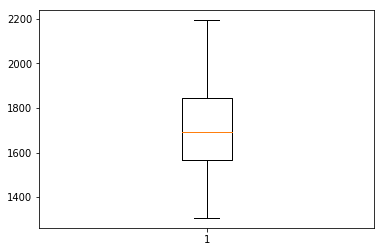

In [20]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values

# data split
n_test = 12

# define config
config = [3, 12, 256, 3, 200, 200, 100]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('convlstm', scores)